In [1]:
import pandas as pd
from data_cleaning.calc_fpoints import calc_fpoints_batter, calc_fpoints_pitcher
from data_cleaning.combine_dfs import combine_metrics_stats, pitch_combine_metrics_stats
from plotting.plots import plot_top_x_corr

In [2]:
# Reading in data and calculating fantasy points
# Minimum PA of 50 for both datasets
pitcher_data = pd.read_csv("data/pitcher_stats_base.csv")
pitcher_fpoints = calc_fpoints_pitcher(pitcher_data, output = False)
pitcher_fpoints.head()


,Name,year,age,IP,H,K,BB,ER,S,W,L,Hold,Fpoints,Fpoints_IP
0,"Colon, Bartolo",2015,42,194.2,217,136,24,90,0,14,13,0,297.6,1.532441
1,"Hawkins, LaTroy",2015,42,38.2,44,34,7,14,3,3,1,7,69.6,1.821990
2,"Wolf, Randy",2015,38,34.2,46,28,15,24,0,0,5,1,21.6,0.631579
3,"Marquis, Jason",2015,36,47.1,64,37,14,34,0,3,4,0,32.3,0.685775
4,"Burnett, A.J.",2015,38,164.0,174,143,49,58,0,9,7,0,296.0,1.804878


In [3]:
pitcher_metrics = pd.read_csv("data/pitcher_metrics.csv")
pitcher_combined = pitch_combine_metrics_stats(pitcher_fpoints, pitcher_metrics, save = False)
pitcher_combined.head()

,Name,Fpoints_IP,year,age,k_percent,bb_percent,xba,xslg,woba,xwoba,...,breaking_avg_break_z_induced,breaking_avg_break,breaking_range_speed,n_offspeed_formatted,offspeed_avg_speed,offspeed_avg_spin,offspeed_avg_break_x,offspeed_avg_break_z,offspeed_avg_break_z_induced,offspeed_avg_break
0,"Colon, Bartolo",1.692469,2016,43,16.7,2.9,0.268,0.427,0.316,0.314,...,3.3,6.5,1.8,7.4,82.6,1727.0,-13.2,-32.0,9.0,16.4
1,"Grilli, Jason",2.169492,2016,39,32.1,7.1,0.221,0.359,0.269,0.275,...,-3.0,12.7,1.2,0.2,86.5,2257.0,-15.3,-26.5,10.8,18.7
2,"Benoit, Joaquín",2.187500,2016,38,24.8,9.1,0.194,0.328,0.243,0.271,...,4.8,6.5,1.8,34.4,84.7,1434.0,-12.4,-36.0,2.8,13.1
3,"Belisle, Matt",2.217391,2016,36,16.8,10.1,0.238,0.320,0.306,0.297,...,0.6,8.8,5.0,3.1,86.4,1838.0,-5.9,-33.6,3.7,7.9
4,"Sabathia, CC",1.655134,2016,35,18.9,6.9,0.253,0.378,0.343,0.304,...,-0.1,11.8,1.5,14.0,83.9,1950.0,11.1,-30.1,9.4,15.0


## EDA

In [4]:
pitcher_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3394 entries, 0 to 3393
Data columns (total 64 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Name                          3394 non-null   object 
 1   Fpoints_IP                    3394 non-null   float64
 2   year                          3394 non-null   int64  
 3   age                           3394 non-null   int64  
 4   k_percent                     3394 non-null   float64
 5   bb_percent                    3394 non-null   float64
 6   xba                           3394 non-null   float64
 7   xslg                          3394 non-null   float64
 8   woba                          3394 non-null   float64
 9   xwoba                         3394 non-null   float64
 10  xobp                          3394 non-null   float64
 11  xiso                          3394 non-null   float64
 12  xwobacon                      3394 non-null   float64
 13  xba

In [5]:
missing_values = pitcher_combined.isna().sum()
missing_values = missing_values[missing_values > 0]
missing_values

arm_angle                       2108
n_breaking_formatted              28
breaking_avg_speed                28
breaking_avg_spin                 28
breaking_avg_break_x              28
breaking_avg_break_z              28
breaking_avg_break_z_induced      28
breaking_avg_break                28
breaking_range_speed              32
n_offspeed_formatted             398
offspeed_avg_speed               398
offspeed_avg_spin                400
offspeed_avg_break_x             398
offspeed_avg_break_z             398
offspeed_avg_break_z_induced     398
offspeed_avg_break               398
dtype: int64

In [6]:
# Need to remove arm_angle. Will impute missing individual pitch data. 
# Year is also not good for prediction since we dont have any 2024 data
pitcher_combined = pitcher_combined.drop(columns = ['year', 'arm_angle'])

/Users/matthewgillies/mlb-fantasy-2025/plotting/plots.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = data.corr()[col].abs().sort_values(ascending=False)


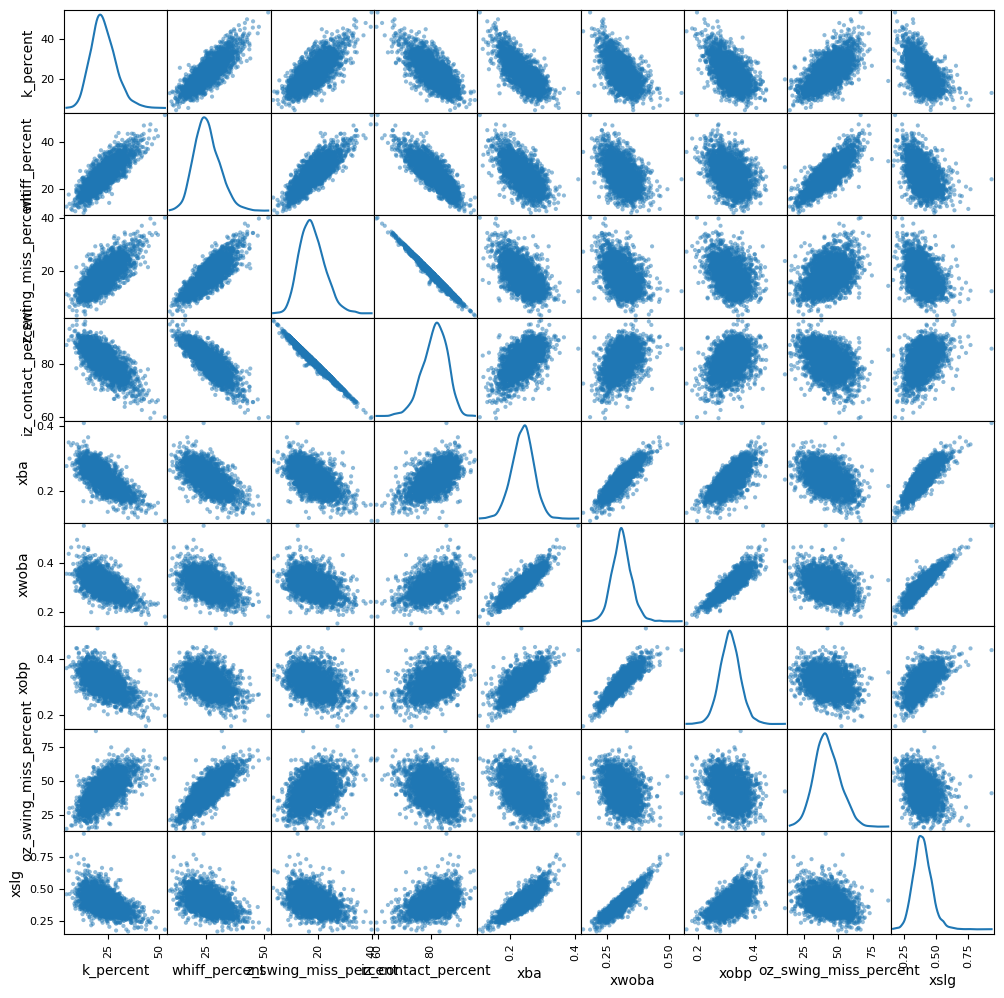

In [7]:
plot_top_x_corr(pitcher_combined, 10, "scatter", "Fpoints_IP")

Many strong correlations throughout, not as many as batting. Normally distributed. 

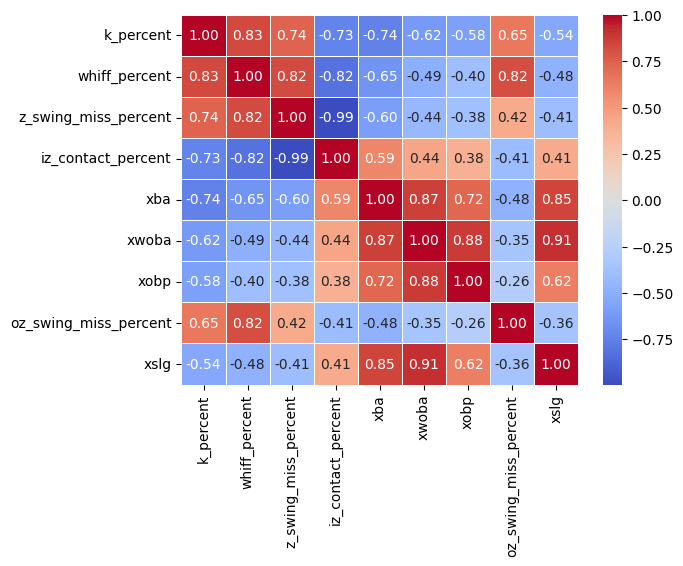

In [8]:
plot_top_x_corr(pitcher_combined, 10, "correlation", "Fpoints_IP")

Some very strong positive and negative correlations here. Will need to be addressed in feature selection